<a href="https://colab.research.google.com/github/beatricekiplagat/Deepfake-Audio-Recognition/blob/dev_branch/SQUEEZENET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# Most Recent One
!pip install git+https://github.com/rcmalli/keras-squeezenet.git
# Release Version
!pip install keras_squeezenet

  Cloning https://github.com/rcmalli/keras-squeezenet.git to /tmp/pip-req-build-8lfaw9_7
  Running command git clone -q https://github.com/rcmalli/keras-squeezenet.git /tmp/pip-req-build-8lfaw9_7


In [18]:
import numpy as np
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras import backend as K
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.utils import layer_utils
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np

In [19]:
#Mount google drive to access data

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

# define train and test data
from PIL import Image
import glob
# train_path = []
# for filename in glob.glob('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train/Spoof/*.png'):
#     im=Image.open(filename)
#     train_path.append(im)
# for filename in glob.glob('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train/Bonafide/*.png'):
#     im=Image.open(filename)
#     train_path.append(im)


# valid_path = []
# for filename in glob.glob('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/Bonafide/*.png'):
#     im=Image.open(filename)
#     valid_path.append(im)
# for filename in glob.glob('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/Spoof/*.png'):
#     im=Image.open(filename)
#     valid_path.append(im)

train_path ='/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train'
test_path = '/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test'

In [21]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [22]:
import pathlib
batch_size = 32
img_height = 224
img_width = 224

In [23]:
import tensorflow as tf
train_ds =tf.keras.preprocessing.image_dataset_from_directory (
    train_path,
    validation_split=0.2 ,
    subset = "training",
    seed = 123,
    image_size = (img_height,img_width),
    batch_size = batch_size)

test_ds =tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    validation_split=0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height,img_width),
    batch_size = batch_size)

Found 1650 files belonging to 2 classes.
Using 1320 files for training.
Found 400 files belonging to 2 classes.
Using 80 files for validation.


In [24]:
#catcheing our data so that it can be saved to our first epoch.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
#normalizing from RBG of range[0,255] to range [0,1] to make it ideal for neural network 
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# # Notice the pixels values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

In [26]:
def squeezenet(input_shape, n_classes):
  
  def fire(x, fs, fe):
    s = Conv2D(fs, 1, activation='relu')(x)
    e1 = Conv2D(fe, 1, activation='relu')(s)
    e3 = Conv2D(fe, 3, padding='same', activation='relu')(s)
    output = Concatenate()([e1, e3])
    return output
  
  
  input = Input(input_shape)
  
  x = Conv2D(96, 7, strides=2, padding='same', activation='relu')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = fire(x, 16, 64)
  x = fire(x, 16, 64)
  x = fire(x, 32, 128)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = fire(x, 32, 128)
  x = fire(x, 48, 192)
  x = fire(x, 48, 192)
  x = fire(x, 64, 256)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = fire(x, 64, 256)
  x = Conv2D(n_classes, 1)(x)
  x = GlobalAvgPool2D()(x)
  
  output = Activation('softmax')(x)
  
  model = Model(input, output)
  return model

In [27]:
# Let's take a look at the base model architecture
input_shape = (img_height,img_width,3)
n_classes = (2)
K.clear_session()
model = squeezenet(input_shape,n_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 96) 14208       input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 96)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 56, 56, 16)   1552        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [28]:
# tell the model what cost and optimization method to use
model.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  optimizer='adam',
  metrics=['accuracy']
uuu)

In [29]:
# fit the model
epochs = 5
history = model.fit(train_ds,
          epochs= epochs,
          validation_data=test_ds 
)

Epoch 1/10
42/42 [==============================] - 231s 5s/step - loss: 0.7034 - accuracy: 0.5053 - val_loss: 0.6938 - val_accuracy: 0.4750
Epoch 2/10
42/42 [==============================] - 198s 5s/step - loss: 0.6810 - accuracy: 0.5417 - val_loss: 0.6538 - val_accuracy: 0.7375
Epoch 3/10
42/42 [==============================] - 199s 5s/step - loss: 0.7032 - accuracy: 0.5008 - val_loss: 0.6936 - val_accuracy: 0.4750
Epoch 4/10
42/42 [==============================] - 200s 5s/step - loss: 0.6935 - accuracy: 0.5144 - val_loss: 0.6935 - val_accuracy: 0.4750
Epoch 5/10
42/42 [==============================] - 198s 5s/step - loss: 0.6932 - accuracy: 0.5144 - val_loss: 0.6943 - val_accuracy: 0.4750
Epoch 6/10
42/42 [==============================] - 198s 5s/step - loss: 0.6929 - accuracy: 0.5144 - val_loss: 0.6921 - val_accuracy: 0.4750
Epoch 7/10
42/42 [==============================] - 198s 5s/step - loss: 0.6892 - accuracy: 0.5235 - val_loss: 0.6925 - val_accuracy: 0.5250
Epoch 8/10
42

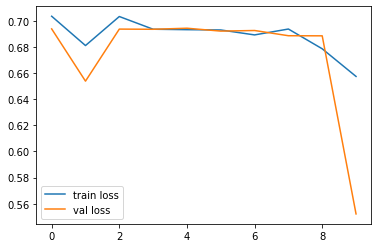

<Figure size 432x288 with 0 Axes>

In [35]:
# loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

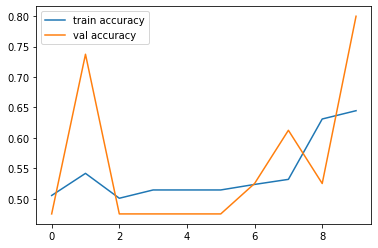

In [36]:
# accuracies
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()